# A segurança alimentar no Ceará em 2024

João Victor Batista Lopes (IPECE - Instituto de Pesquisa e Estratégia Econômica do Ceará)

In [ ]:
library(devtools)

Carregando pacotes exigidos: usethis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Anexando pacote: 'srvyr'

O seguinte objeto é mascarado por 'package:stats':

    filter

        R/dados_svy_ce.R R/dados_svy_san_ce.R R/make_panel_san.R R/pnad2004.R
value   ?                ?                    ?                  ?           
visible FALSE            FALSE                FALSE              FALSE       
        R/pnad2009.R R/pnad2013.R R/pnada_labeller.R R/pnadc.R
value   ?            ?            ?                  ?        
visible FALSE        FALSE        FALSE              FALSE    
        R/pnadc_download.R R/pof.R R/pof_labeller.R R/read_pnada.R R/read_pof.R
value   ?                  ?       ?                ?              ?           
visible FALSE              FALSE   FALSE            FALSE          FALSE       

## Introdução

O Instituto Brasileiro de Geografia e Estatística (IBGE) disponibilizou os dados da última aplicação da Escala Brasileira de Insegurança Alimentar (EBIA) no ano de 2024, por meio da Pesquisa Nacional por Amostra de Domicílios Contínua (PNAD) Contínua. Essa é a quinta vez que o IBGE divulga uma série de resultados sobre o tema, o que permite a comparação da evolução dos indicadores de Segurança Alimentar e Nutricional (SAN), ao longo dos anos. Os resultados se referem às situações vivenciadas pelos moradores dos domicílios particulares permanentes nos últimos três meses anteriores à pesquisa, realizada no quarto trimestre de 2024. De acordo com os resultados, os domicílios podem ser classificados em Segurança Alimentar (SA) e Insegurança Alimentar (IA), classificada em três níveis leve, moderada ou grave

## Evolução da prevalência de segurança e insegurança alimentar no Ceará

In [ ]:
dados <- readRDS("data/clean_data/painel_san.RDS")

In [ ]:
# Paleta de cores
paleta_san <- scale_fill_manual(
  values = c("#2ecc71", "#f39c12", "#e67e22", "#e74c3c"),
  name = "Situação de Segurança Alimentar",
  labels = c("Segurança alimentar", "IA leve", "IA moderada", "IA grave")
)

# As vezes precisa dela invertida
paleta_san_invertida <- scale_fill_manual(
    values = c("#e74c3c", "#e67e22", "#f39c12","#2ecc71"),
    name = "Situação de Segurança Alimentar",
    labels = c("IA grave", "IA moderada", "IA leve","Segurança alimentar")
  )

# Eixo Y padrão
eixo_y_percentual <- scale_y_continuous(
  labels = scales::percent,
  limits = c(0, NA)
)

# Tema customizado
tema_san <- theme_minimal(base_size = 8) +
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title.position = "top",
    legend.title = element_text(face = "bold", size = 8),
    strip.text = element_text(face = "bold", size = 8),
    strip.background = element_rect(fill = "grey90", color = NA),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 8),
    plot.subtitle = element_text(hjust = 0.5, size = 8),
    plot.caption = element_text(hjust = 0, size = 8, color = "grey40"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 8),
    axis.text.y = element_text(size = 8)
  )

Em 2024, 69,5% dos domicílios cearenses estavam em situação de segurança alimentar, que ocorre quando os moradores têm acesso regular e permanente a alimentos de qualidade e em quantidade suficiente. Esse é o maior valor da série histórica iniciada em 2004, quando o IBGE aplicou pela primeira vez a Escala Brasileira de Insegurança Alimentar (EBIA) para investigar a situação de segurança alimentar nos domicílios brasileiros na extinta Pesquisa Nacional por Amostra de Domicílios (PNAD), conforme pode ser verificado na @fig-evolucao.

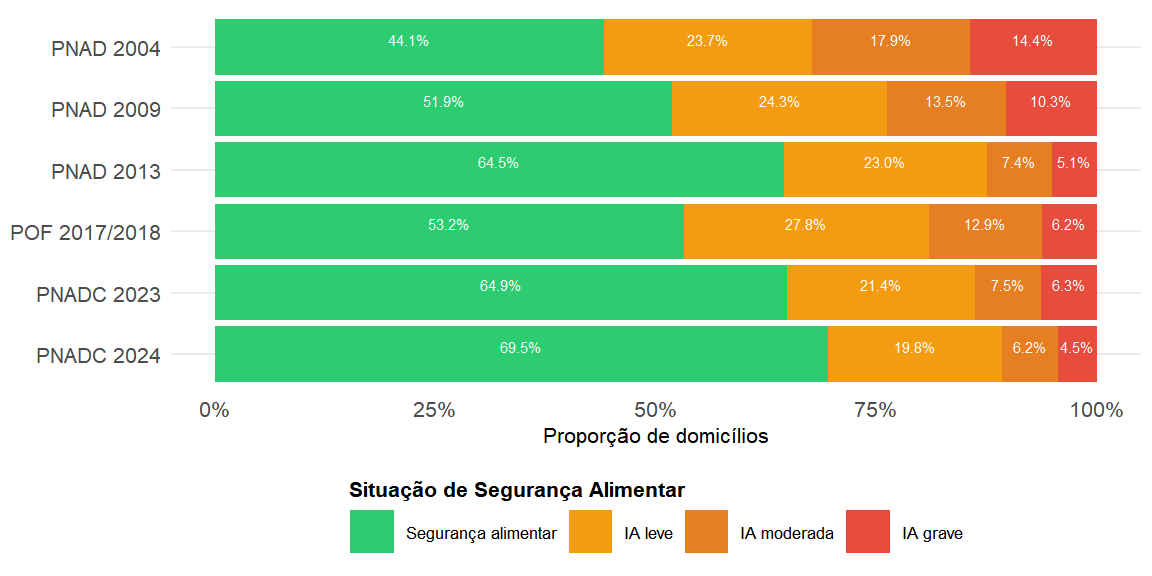

In [ ]:
dados_svy <- dados[!is.na(dados$peso),] |> 
  filter(posicao=="Pessoa responsável") |> 
  as_survey_design(
    weights = peso,
    strata = estrato
  )

dados_svy |> 
  filter(posicao == "Pessoa responsável" & uf == "Ceará" & !is.na(san)) |>
  group_by(ano, san) |>
  summarise(
    n = survey_total(),
    proporcao = survey_mean()
  ) |>
  mutate(ano = fct_rev(ano),
         san=fct_rev(san)) |> 
  ggplot(aes(ano, proporcao, fill = san)) +
  geom_col(position = "stack") +
  coord_flip()+
  labs(
    #title = "Evolução da prevalência de segurança alimentar e insegurança leve,\nmoderada e grave nos domicílios particulares permanentes",
    #subtitle = "Ceará",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    vjust = -0.2, 
    position = position_stack(vjust = 0.5),
    size = 2,
    color ="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

Consequentemente, de forma inversa, o percentual de domicílios nos quais os moradores, inclusive as crianças, ficaram um dia inteiro sem comer por falta de dinheiro para comprar alimentos (IA grave), atingiu o menor valor nos últimos 20 anos. Entre 2023 e 2024, o percentual dos domicílios cearenses que estavam em situação de insegurança alimentar grave caiu de 6,3% para 4,5% no último ano. Esse valor é menor inclusive do que o percentual observado em 2013 (5,1%) no Ceará, quando o Brasil saiu pela primeira vez do Mapa da Fome, segundo a Organização das Nações Unidas para a Alimentação e a Agricultura (FAO). No mesmo período, a insegurança alimentar leve teve queda de 21,4% para 19,8%, enquanto a moderada, caiu de 7,5% para 6,2%. Ao todo, a proporção de domicílios cearenses com algum grau de insegurança alimentar recuou de 35,1% para 30,5% entre 2023 e 2024. De modo que, é possível verificar que a redução foi mais intensa na insegurança alimentar grave que caiu -1,8 pontos percentuais, enquanto a IA leve e a moderada caíram -1,6 e -1,3 p.p., respectivamente.

Em números absolutos, dos 9,195 milhões de pessoas na população do Ceará estimada pela PNAD Contínua no quarto trimestre de 2024, mais de 3 milhões, o equivalente a 32,5% da população total, sofreram algum grau de insegurança alimentar. Destes, 391 mil tiveram que reduzir a quantidade de alimentos consumidos, chegando até mesmo a passar fome (IA Grave). Apesar dessa realidade ainda angustiante, em comparação ao ano de 2023, mil cearenses deixaram de passar fome. Isso representou uma redução de -27,6% no total de cearenses em situação alimentar grave no último ano.

In [ ]:
bind_rows(
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & posicao == "Pessoa responsável" & uf == "Ceará") |>
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Domicílios"),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & posicao == "Pessoa responsável" & uf == "Ceará") |>
    mutate(san=if_else(san %in% c("Insegurança alimentar leve", "Insegurança alimentar moderada", "Insegurança alimentar grave"), "Insegurança alimentar", san),
           Tipo = "Domicílios") |>
    filter(san=="Insegurança alimentar") |> 
    count(ano, san, situacao, Tipo, wt=peso),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & posicao == "Pessoa responsável" & uf == "Ceará") |>
    mutate(san="Total") |> 
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Domicílios"),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & uf == "Ceará") |>
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Moradores"),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & uf == "Ceará") |>
    mutate(san=if_else(san %in% c("Insegurança alimentar leve", "Insegurança alimentar moderada", "Insegurança alimentar grave"), "Insegurança alimentar", san),
           Tipo = "Moradores") |>
    filter(san=="Insegurança alimentar") |> 
    count(ano, san, situacao, Tipo, wt=peso),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & uf == "Ceará") |>
    mutate(san="Total") |> 
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Moradores")
) |> 
  mutate(n = n/1000) |>
  pivot_wider(names_from = c(Tipo, situacao), 
              values_from = n,
              names_glue = "{Tipo}_{situacao}") |>
  mutate(`Domicílios_Total` = `Domicílios_Urbana` + `Domicílios_Rural`, .after = `Domicílios_Urbana`) |> 
  mutate(`Moradores_Total` = `Moradores_Urbana` + `Moradores_Rural`, .after = `Moradores_Urbana`) |>
  group_by(ano) |>
  gt() |>
  # tab_header(
  #   title = "Insegurança Alimentar no Ceará (em milhares)",
  #   subtitle = "Ceará – 2023 e 2024"
  #   ) |>
  tab_spanner(label = "Domicílios", columns = starts_with("Domicílios")) |>
  tab_spanner(label = "Moradores", columns = starts_with("Moradores")) |>
  cols_label(
    san = "Categoria",
    `Domicílios_Urbana` = "Urbana",
    `Domicílios_Rural` = "Rural",
    `Domicílios_Total` = "Total",
    `Moradores_Urbana` = "Urbana",
    `Moradores_Rural` = "Rural",
    `Moradores_Total` = "Total"
  ) |>
  fmt_number(decimals = 0, locale = "pt") |>
  tab_style(
    style = list(cell_fill(color = "#E3F2FD"), cell_text(weight = "bold")),
    locations = cells_body(columns = c(`Domicílios_Total`, `Moradores_Total`))
    ) |>
  tab_style(
    style = cell_text(weight = "bold", align = "center"),
    locations = cells_row_groups()
  ) |> 
  # Fonte da tabela
  # tab_source_note(source_note = "Fonte: PNAD Contínua/IBGE") |>
  # Tema geral
  tab_options(
    table.font.size = px(12),
    heading.align = "center",
    column_labels.font.weight = "bold",
    source_notes.font.size = px(10),
    row_group.background.color = "#1976D2",
    heading.background.color = "#0D47A1"
  )

## Situação de segurança alimentar no Ceará e recortes geográficos

A @fig-situacao mostra a prevalência de segurança alimentar por situação do domicílio. Há melhora nos indicadores de segurança alimentar tanto nos domicílios da área urbana quanto rural. Na zona rural a proporção de domicílios em Insegurança alimentar grave caiu de 6,3% para 3,8% em 2024, entretanto, a insan leve está presente em 26,4% dos domicílios. 61,9% dos domicílios apresentam segurança alimentar.

Nos domicílios da zona urbana, 71,5% apresentam segurança alimentar. Dentre os que apresentaram algum tipo de insegurança, 4,3% foi do tipo grave.

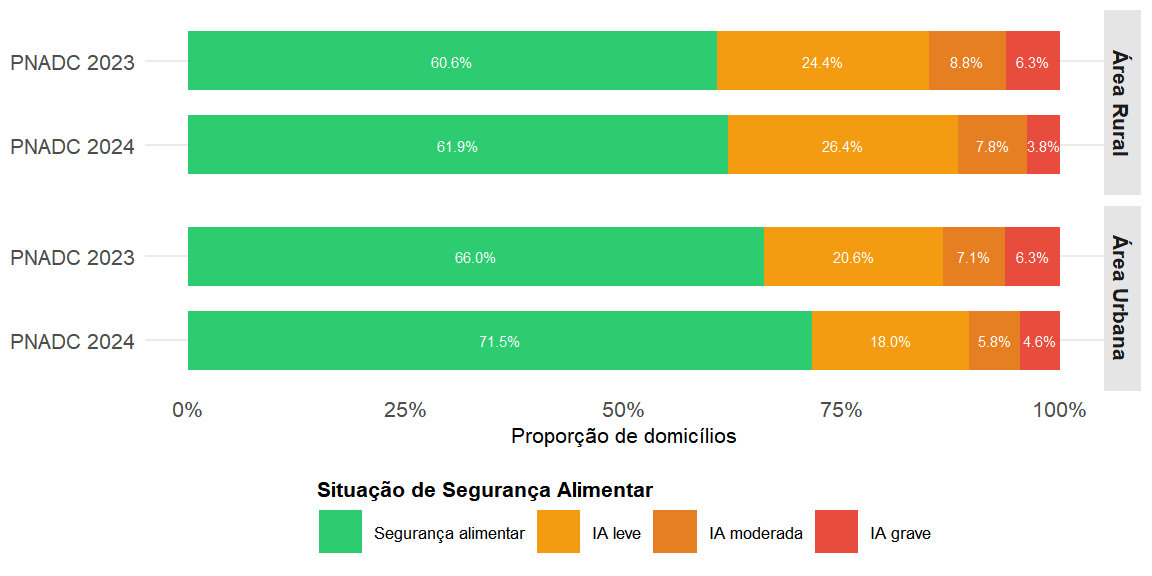

In [ ]:
dados_svy_ce(dados, situacao) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  facet_grid(situacao ~ ., 
             labeller = labeller(situacao = c(Urbana = "Área Urbana", 
                                            Rural = "Área Rural")))+
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    color="white")+
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo a situação do domicílio",
    #subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  )+
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

A @fig-estratos apresenta o percentual de domicílios particulares permanentes por situação de segurança alimentar de acordo com o estrato geográfico do estado do Ceará. Os estratos que apresentaram maior segurança alimentar foram o município de Fortaleza (76,3%) seguido do seu entorno metropolitano (72,5%) e o Litoral Ocidental e Norte (70,8%). O Litoral Oriental - Vale do Rio Jaguaribe apresenta a menor proporção de domicílios em segurança alimentar.

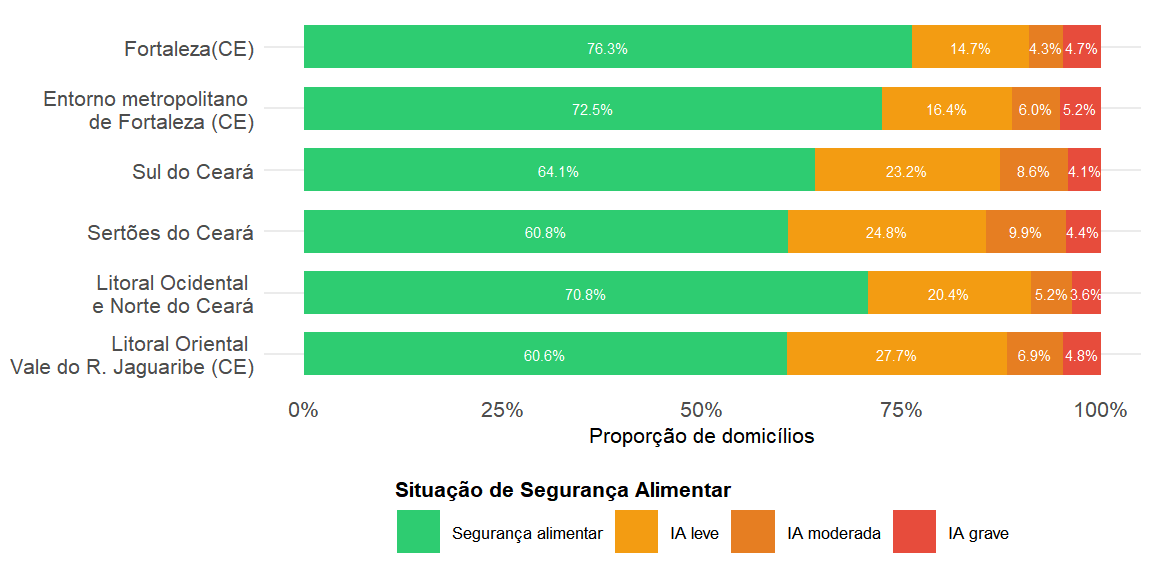

In [ ]:
dados |> 
  dados_svy_ce(estrato) |> 
  filter(ano=="PNADC 2024") |> 
  mutate(estrato = fct_recode(estrato, 
                              "Fortaleza(CE)" = "2310",
                              "Entorno metropolitano \nde Fortaleza (CE)" = "2320",
                              "Litoral Ocidental \ne Norte do Ceará"= "2353",
                              "Litoral Oriental \nVale do R. Jaguaribe (CE)"="2354",
                              "Sertões do Ceará"="2352",
                              "Sul do Ceará"="2351")) |> 
  ggplot(aes(fct_rev(estrato), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  labs(
    #title = "Percentual de domicílios particulares permanentes por situação de segurança alimentar, segundo os recortes geográficos",
    #subtitle = "Ceará – 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

Curiosamente, o Entorno Metropolitano de Fortaleza, apesar da grande proporção de domicílios em segurança alimentar, também apresenta a maior proporção de domicílios em insan grave, com 5,2%. Analisando o distribuição por estrato geográfico de acordo com a situação de insegurança alimentar (@fig-distribuicaoestratos) , podemos ver que esse estrato corresponde a 15% do total de domicílios, mas também a 17,4% daqueles em insam grave. Esse fenômeno também ocorre com Fortaleza, que representa 29,1% do total de domicílios mas também a 30,9% do total de insam grave.

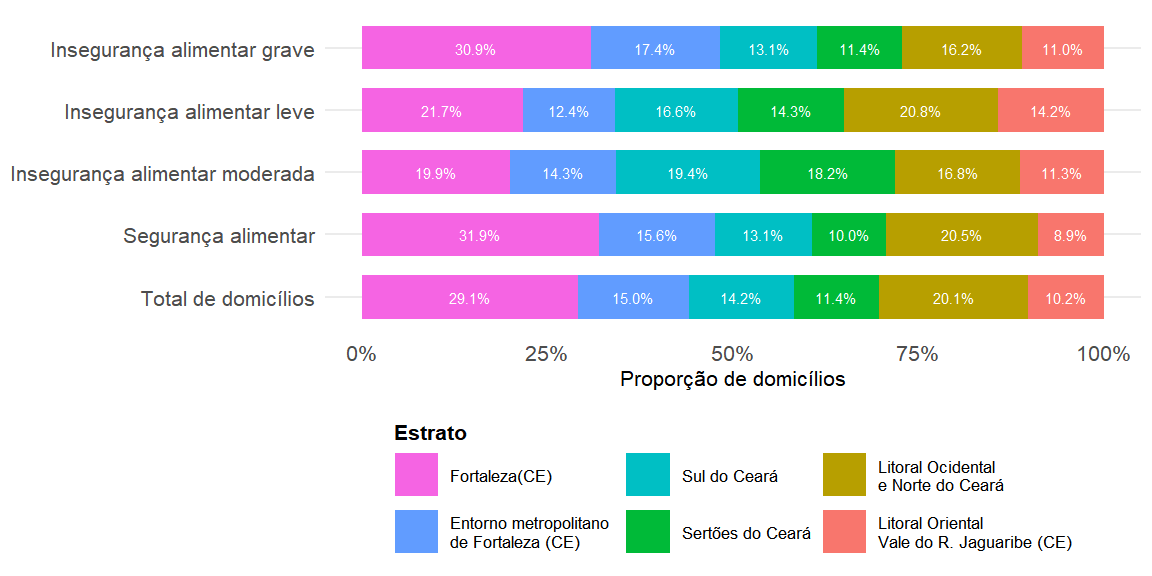

In [ ]:
bind_rows(
  dados |> 
    mutate(san = "Total de domicílios") |> 
    dados_svy_san_ce(estrato)|> 
    filter(ano=="PNADC 2024"),
  dados |> 
    dados_svy_san_ce(estrato)|> 
    filter(ano=="PNADC 2024")
) |> 
  mutate(estrato = fct_recode(estrato, 
                              "Fortaleza(CE)" = "2310",
                              "Entorno metropolitano \nde Fortaleza (CE)" = "2320",
                              "Litoral Ocidental \ne Norte do Ceará"= "2353",
                              "Litoral Oriental \nVale do R. Jaguaribe (CE)"="2354",
                              "Sertões do Ceará"="2352",
                              "Sul do Ceará"="2351")) |> 
  ggplot(aes(fct_rev(san), proporcao, fill = fct_rev(estrato))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  labs(
    #title = "Percentual de domicílios particulares permanentes por situação de segurança alimentar, segundo os recortes geográficos",
    #subtitle = "Ceará – 2024",
    y = "Proporção de domicílios",
    x = NULL,
    fill = "Estrato"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    color="white"
  ) +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Situação de segurança alimentar: comparação Brasil, Nordeste e Ceará

In [ ]:
indicadores <- dados |> 
  filter(ano == "PNADC 2024" & posicao == "Pessoa responsável" & !is.na(peso)) |> 
  mutate(
    # Região
    regiao = case_when(
      uf %in% c("Maranhão", "Piauí", "Ceará", "Rio Grande do Norte",
                "Paraíba", "Pernambuco", "Alagoas", "Sergipe", "Bahia") ~ "Nordeste",
      TRUE ~ "Outras"
    )) |> 
  filter(uf == "Ceará" | regiao == "Nordeste") |>
  mutate(grupo = case_when(
    uf == "Ceará" ~ "Ceará",
    regiao == "Nordeste" ~ "Nordeste",
    TRUE ~ NA_character_)) |>
  as_survey_design(weights = peso) |> 
  group_by(grupo, san) |>
  summarise(
      n = survey_total(),
      .groups = "drop"
    ) |>
  group_by(grupo) |>
  mutate(
      populacao = sum(n),
      proporcao = n / populacao
    ) |>
  ungroup()

brasil <- dados |> 
  filter(ano == "PNADC 2024" & posicao == "Pessoa responsável" & !is.na(peso)) |> 
  as_survey_design(weights = peso) |> 
  group_by(san) |>
  summarise(
    grupo="Brasil",
    n = survey_total(),
    .groups = "drop"
    ) |>
  group_by(grupo) |>
  mutate(
      populacao = sum(n),
      proporcao = n / populacao
    ) |>
  ungroup()

indicadores <- bind_rows(indicadores, brasil)

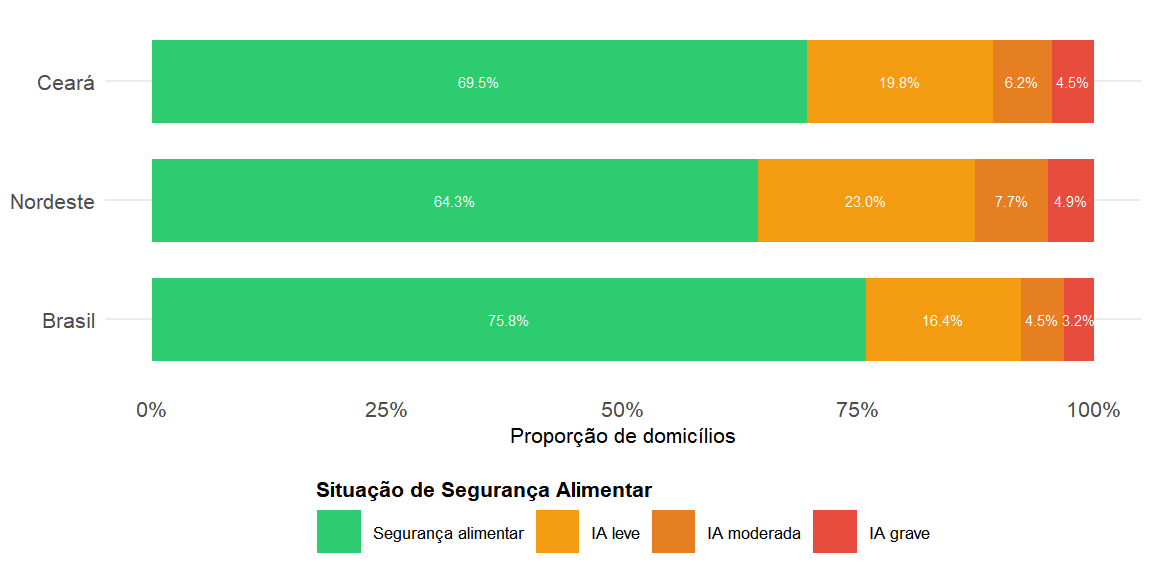

In [ ]:
indicadores |> 
  mutate(grupo = fct_relevel(grupo, "Ceará", "Nordeste", "Brasil")) |> 
  ggplot(aes(fct_rev(grupo), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o sexo da pessoa responsável pelo domicílio",
    #subtitle = "Brasil, Nordeste e Ceará – 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Características dos domicílios e de seus moradores

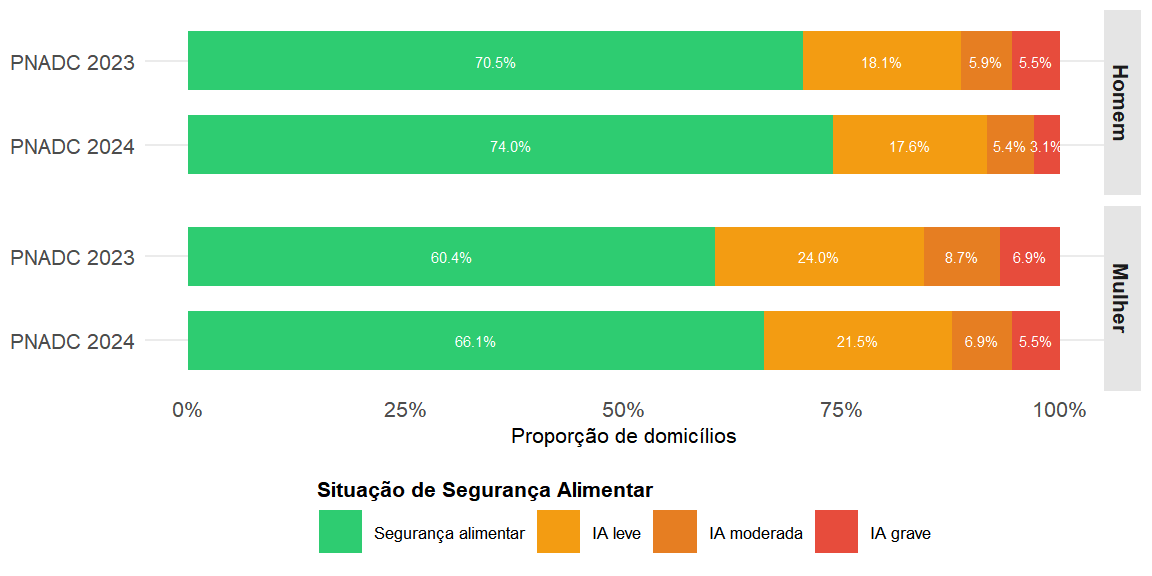

In [ ]:
dados_svy_ce(dados, sexo) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  facet_grid(sexo ~ .)+
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o sexo da pessoa responsável pelo domicílio",
    #subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

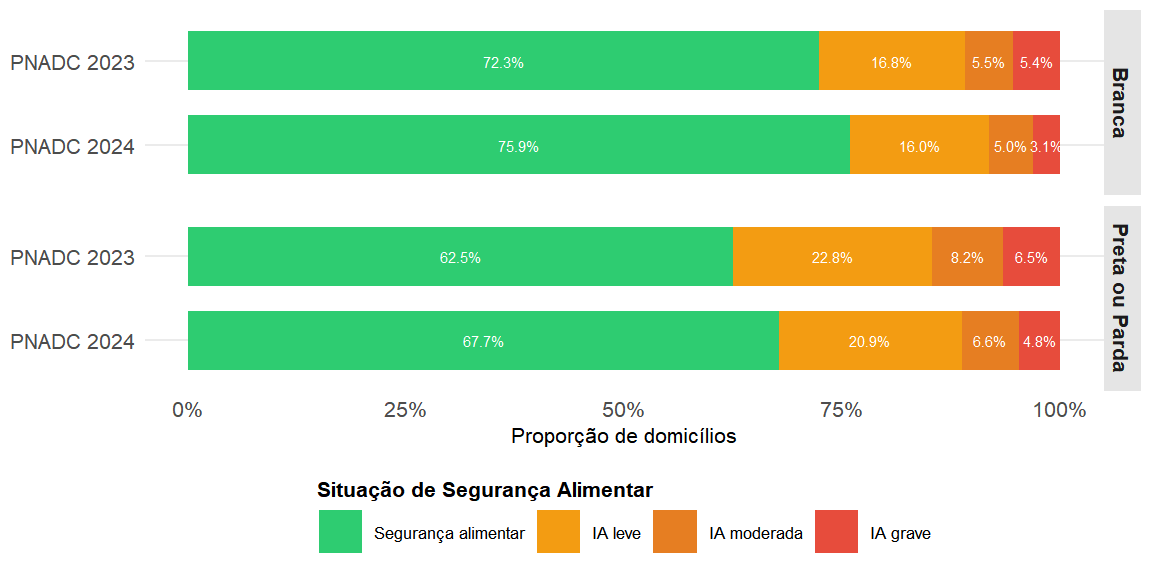

In [ ]:
dados |>
  mutate(
    raca = case_when(
      raca == "Branca" ~ "Branca",
      raca == "Preta" ~ "Preta ou Parda",
      raca == "Parda" ~ "Preta ou Parda",
      TRUE ~ "Outras"
    )
  ) |> 
  dados_svy_ce(raca) |> 
  filter(raca %in% c("Branca", "Preta ou Parda")) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(raca ~ .) +
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo a raça da pessoa responsável pelo domicílio",
    #subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 2,
    colour="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

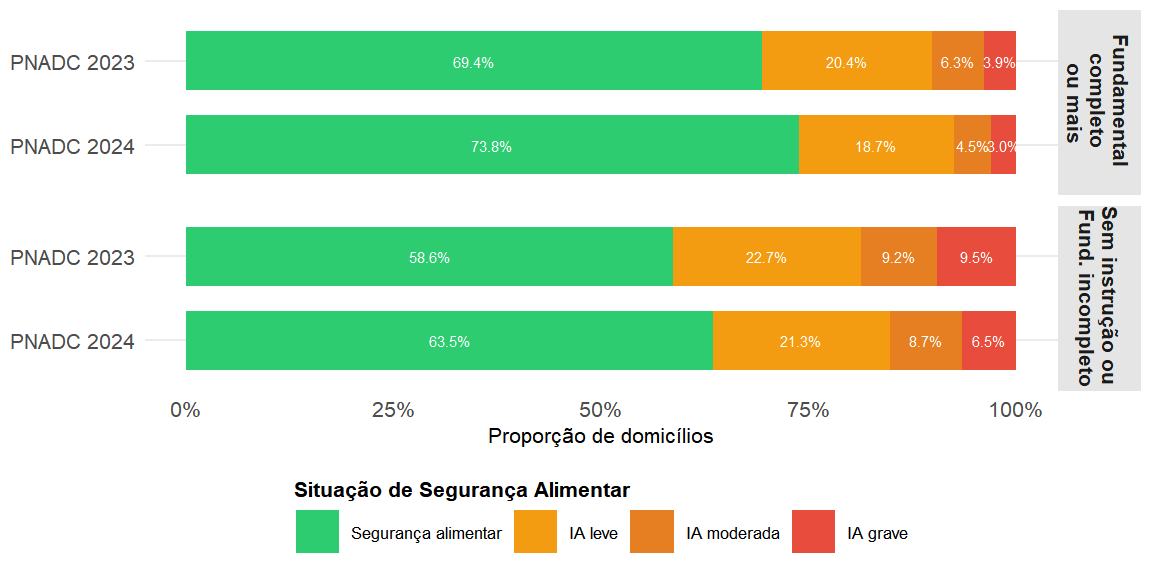

In [ ]:
dados |>
  mutate(
    faixa_escolaridade = case_when(
      faixa_escolaridade == "Sem instrução e menos de 1 ano de estudo" ~ "Sem instrução ou \nFund. incompleto",
      faixa_escolaridade == "Fundamental incompleto ou equivalente" ~ "Sem instrução ou \nFund. incompleto",
      TRUE ~ "Fundamental \ncompleto \nou mais"
    )) |> 
  dados_svy_ce(faixa_escolaridade) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(faixa_escolaridade ~ .) +
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o nível de escolaridade da pessoa responsável pelo domicílio",
    #subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust=0.5),
    size = 2,
    colour="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

Warning in geom_text(aes(label = scales::percent(proporcao, accuracy = 0.1)), :
Ignoring unknown parameters: `face`

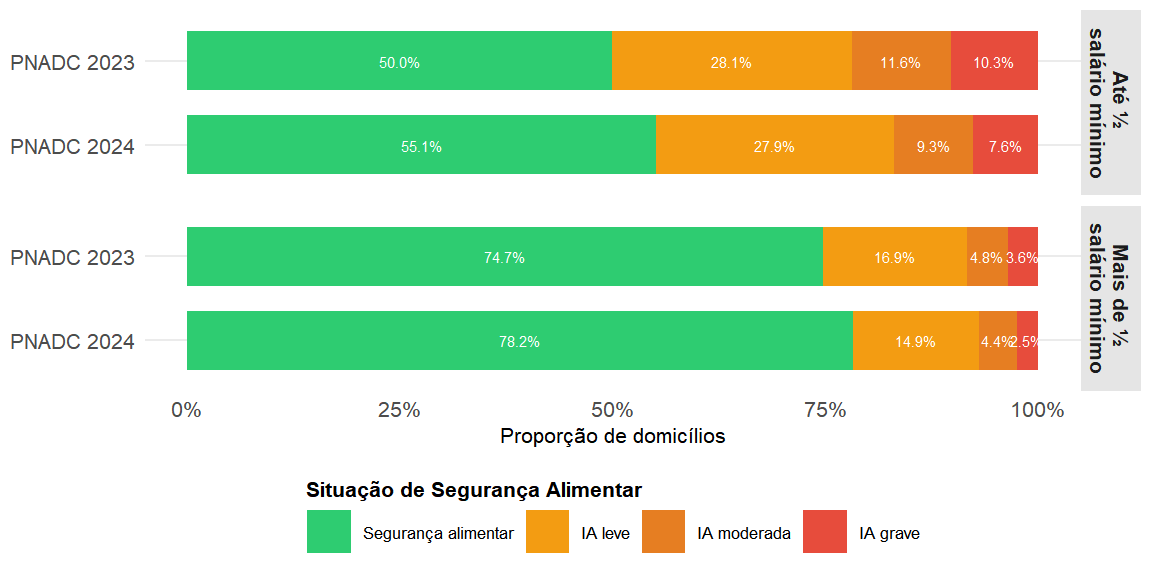

In [ ]:
dados |>
  mutate(
    faixa_renda = case_when(
      faixa_renda == "Até ¼ salário mínimo" ~ "Até ½ \nsalário mínimo",
      faixa_renda == "Mais de ¼ até ½ salário mínimo" ~ "Até ½ \nsalário mínimo",
      TRUE ~ "Mais de ½ \nsalário mínimo"
    )) |> 
  dados_svy_ce(faixa_renda) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(faixa_renda ~ .) +
  labs(
    #title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo as classes de rendimento domiciliar per capita",
    #subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    #caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust=0.5),
    size = 2, face = "bold",
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Considerações finais